# Reinforcement Learning

In [4]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('qDNA-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

## Benchmark Environment Step Function 

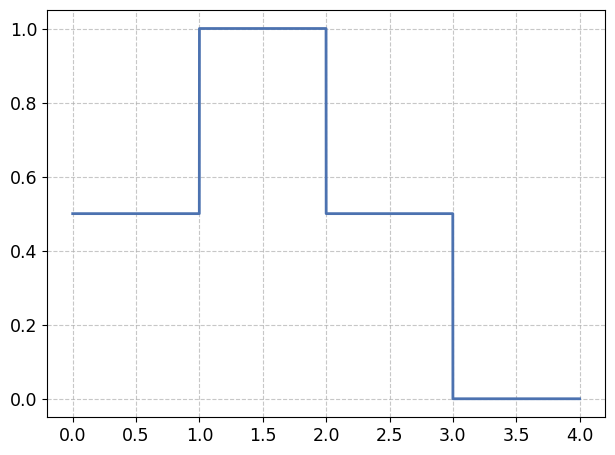

In [5]:
# without step function

register_config = [('NV0', (0, 0, 0), 0, {})]
kwargs = dict(instant_pulses = True, verbose = False, target=q.Qobj(np.array([[0.5, 0.5j], [-0.5j, 0.5]])))

env = Environment(register_config, [], **kwargs)
pulse_seq = [1e-6, 1e-6, 1e-6, 1e-6, np.pi/2, np.pi/2, np.pi/2, 0, 0, 0]
t_list = list(np.arange(0, 4.1e-6, 0.1e-6))
t_list.extend([1e-6-1e-9, 2e-6-1e-9, 3e-6-1e-9])
t_list = np.array(sorted(t_list))
fidelities = env.get_values(pulse_seq, 'fidelity', t_list=t_list)

fig, ax = plt.subplots()
ax.plot(t_list*1e6, fidelities)
plt.show()

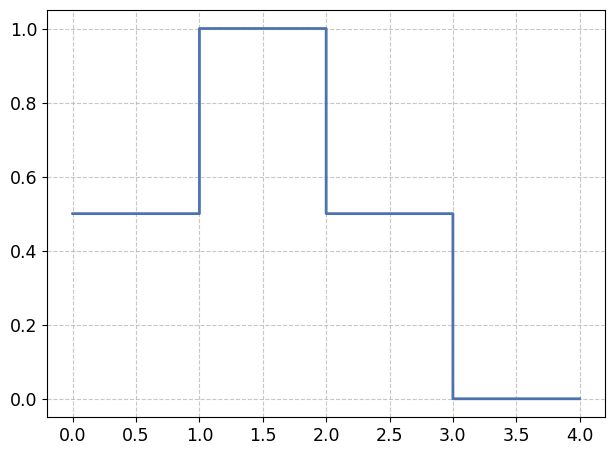

In [6]:
# with step function

register_config = [('NV0', (0, 0, 0), 0, {})]
kwargs = dict(instant_pulses = True, verbose = False, target=q.Qobj(np.array([[0.5, 0.5j], [-0.5j, 0.5]])), skip_first_evo=True)

env = Environment(register_config, [], **kwargs)
fidelities = []
fidelities.append(env.fidelity)
for _ in range(10):
    env.step([0.1e-6, 0, 0])
    fidelities.append(env.fidelity)
env.step([0, 1/4, 0])
fidelities.append(env.fidelity)

for _ in range(10):
    env.step([0.1e-6, 0, 0])
    fidelities.append(env.fidelity)
env.step([0, 1/4, 0])
fidelities.append(env.fidelity)

for _ in range(10):
    env.step([0.1e-6, 0, 0])
    fidelities.append(env.fidelity)
env.step([0, 1/4, 0])
fidelities.append(env.fidelity)

for _ in range(10):
    env.step([0.1e-6, 0, 0])
    fidelities.append(env.fidelity)

t_list = list(np.arange(0, 4.1e-6, 0.1e-6))
t_list.extend([1e-6, 2e-6, 3e-6])
t_list = np.array(sorted(t_list))

fig, ax = plt.subplots()
ax.plot(t_list*1e6, fidelities)
plt.show()